# Methylation and Deamination Estimators Simulation

author: lee.carlin@mail.huji.ac.il  
date: 2020-03-23

Table of Contents:  
    * [Simple Binomial Model](#A-Simple-Binomial-Model)  
    * [A Read Position Binomial Model](#A-Read-Position-Binomial-Model)  
    * [A Read Position GLM Model](#A-Read-Position-GLM-Model) 

In [163]:
# libraries:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, newton
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.optimize import fsolve, newton

# A Simple Binomial Model  

* $n_i$ is the total coverage at position $i$  
* $t_i, c_i$ are the total numbers of observed T and C bases at $i$ , respectively.   
* $n_i=t_i+c_i$  
* $m_i$ is the methylation level at position $i$, $0<=m_i<=1$  
* $\pi$ is the average deamination rate over all reads.   

$t_i$ is generated according to the following binomial process:    
$t_i \sim Bin(n_i,\pi m_i)$   

The ML:  
$L(\pi m_i|n_i,t_i) = \binom{n_i}{t_i} (\pi m_i)^{t_i}(1-\pi m_i)^{n_i-t_i}$m

The MLE:  
$\hat{\pi m_i}  = \frac{t_i}{n_i}$

### Simulation:

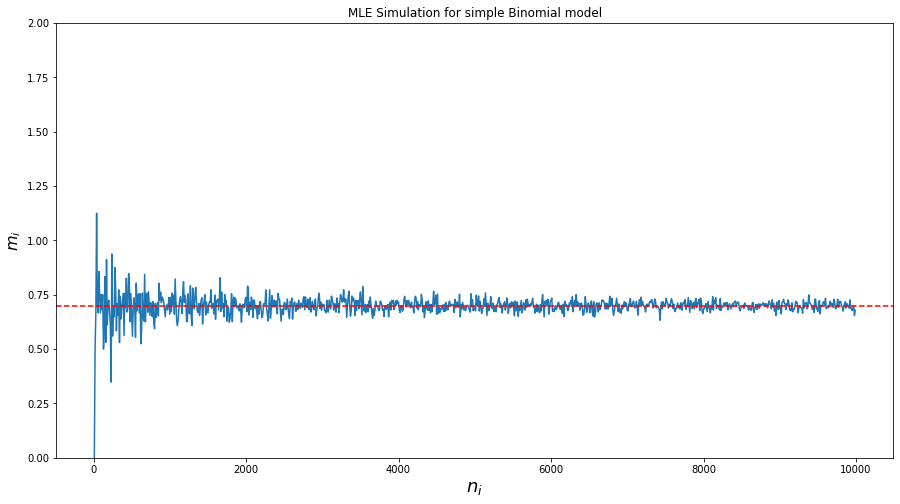

In [256]:
# Setting parameters 
max_n_i = 10000
m_i = 0.7
pi = 0.2
n_i = 30
# Sampling datapoints:
t_i = np.random.binomial(1,pi*m_i,n_i)
# Using sample to calculate estimator:
# estimator = t_i.sum()/(n_i*pi)
est_list = []
rng = range(10,max_n_i,10)
for i in rng:
    est_list.append(np.random.binomial(1,pi*m_i,i).sum()/(i*pi))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),est_list,)
ax.axhline(y=m_i, color = 'red', ls='--')
ax.set_title('MLE Simulation for simple Binomial model')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,2])
plt.show()

# A Read Position Binomial Model 

### In this variation the deamination rate is free to vary between read position $j$. 

$t_{i,j} \sim Bern(\theta_{i,j}) \quad \text{where} \quad \theta_{i,j} = \pi_{i,j}^1 m_i +\pi_{i,j}^0  (1- m_i)$  


We first simplify by using   $\quad \theta_{i,j} = \pi_{i,j}^1 m_i $

### The FOC of the MLE is:

$\frac{ \partial \mathbf{l}(\theta_{i,j})}{ \partial \theta_{i,j}	}  
 =\sum_{t_{i,j}}^{k_i} t_{i,j} \frac{\partial \partial (\theta_{i,j})}{\theta_{i,j}}
 - \sum_{t_{i,j}}^{k_i} (1-t_{i,j}) \frac{\partial \partial (\theta_{i,j})}{1-\theta_{i,j}} $ 
  
  where $ \partial \partial (\theta_{i,j})$ is the partial derivative of $\theta_{i,j}$ with respect to one of its variables. 
 

If we choose to take the partial derivative with respect to $m_i$, then

$\frac{ \partial \mathbf{l}(\theta_{i,j})}{ \partial \theta_{i,j}	}  
=  \sum_{t_{i,j}}^{k_i} t_{i,j} \frac{\pi_{i,j}}{\theta_{i,j}}
- \sum_{t_{i,j}}^{k_i} (1-t_{i,j}) \frac{\pi_{i,j}}{1-\theta_{i,j}}$

### Simulation:

Setting Parameters:

In [218]:
n_i =  30 # number of coverage per read
m_i =  0.7 # min(np.random.uniform(0.7, 0.15),1)
p_i = 0.2
#pi_i = np.random.binomial(1,pi_high_ratio,n_i).astype(float)
#pi_i[pi_i==1] = pi_high
#pi_i[pi_i==0] = pi_low

Number of coverage per read: 30
The true m_i: 0.700


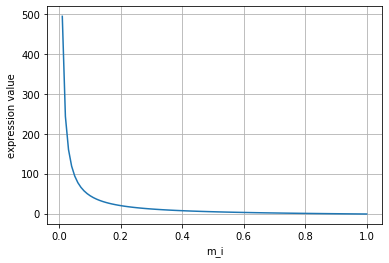

m_i is = 0.7
The solution is m_i = 0.8333333333333327
at which the value of the expression is 4.440892098500626e-15


In [250]:

# Define the expression whose roots we want to find:
print('Number of coverage per read: {:,}'.format(n_i))
print('The true m_i: {:.3f}'.format(m_i))
# Plot it
t_i = np.random.binomial(1,pi*m_i,n_i)
def FOC(M_i,n_i,p_i):    
    A = ((t_i*p_i)/(p_i*M_i)).sum()
    oneMinusT = np.array([1]*n_i)-np.array(t_i)
    oneMinusTheta = np.array([1]*n_i)-p_i*M_i
    B = ((oneMinusT*p_i)/(oneMinusTheta)).sum()
    return (A-B)
#func = lambda M_i : ((t_i*pi_i)/(pi_i*M_i)).sum()-((np.array([1]*n_i)-np.array(t_i)*pi_i)/(np.array([1]*n_i)-pi_i*M_i)).sum()

MM_i = np.linspace(0.01, 1, 99)
y = []
for i in MM_i:
    y.append(FOC(i,n_i,p_i))

plt.plot(MM_i, y)
plt.xlabel("m_i")
plt.ylabel("expression value")
plt.grid()
plt.show()


m_i_initial_guess = 0.5
#m_i_solution = sp.optimize.brentq(FOC, 0.1,1)
m_i_solution = fsolve(FOC, m_i_initial_guess,args=(n_i,p_i))

print("m_i is = {}".format(m_i))
print("The solution is m_i = {}".format(m_i_solution[0]))
print("at which the value of the expression is {}".format(FOC(m_i_solution,n_i,p_i)))

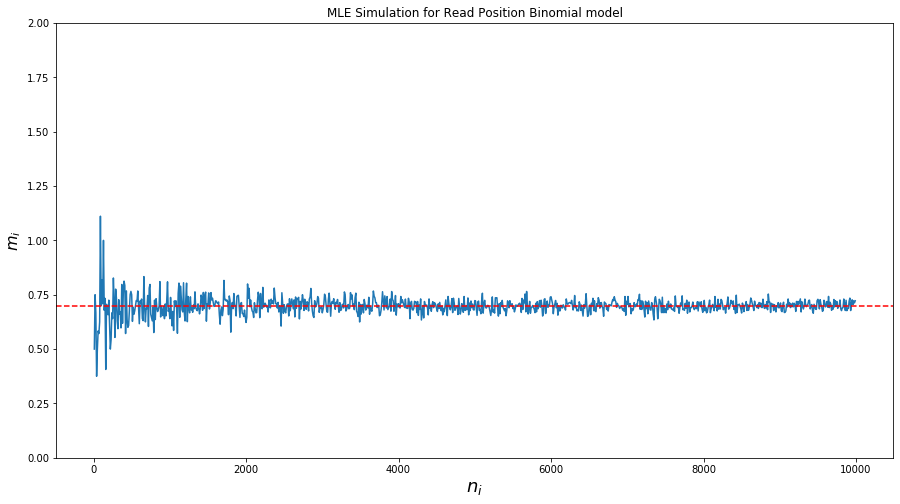

In [257]:
max_n_i = 10000
# Plotting the simulation per coverage size:
est_list = []
rng = range(10,max_n_i,10)
for i in rng:
    t_i = np.random.binomial(1,pi*m_i,i)
    solution = fsolve(FOC, m_i_initial_guess,args=(i,p_i))[0]
    #print(solution)
    est_list.append(solution)
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),est_list,)
ax.axhline(y=m_i, color = 'red', ls='--')
ax.set_title('MLE Simulation for Read Position Binomial model')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,2])
plt.show()

# A Read Position GLM Model 

## WORK IN PROGRESS
(I still have a few issues here)

The Model:

In [263]:
#help(sm.families)

In [291]:
## 

In [290]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({"t_i": t_i,
                   "p_i": pi})
from patsy import dmatrices
y, X = dmatrices('t_i ~ p_i', df, return_type = 'dataframe')


lr_fi_true = LinearRegression(fit_intercept=True)
lr_fi_false = LinearRegression(fit_intercept=False)

lr_fi_true.fit(X, y)
lr_fi_false.fit(X, y)

#print('Intercept when fit_intercept=True : {:.5f}'.format(lr_fi_true.intercept_))
print('Intercept when fit_intercept=False : {:.5f}'.format(lr_fi_false.intercept_))
lr_fi_false.coef_

Intercept when fit_intercept=False : 0.00000


array([[ 1.03349116e+11, -5.16745579e+11]])

In [283]:

df = pd.DataFrame({"t_i": t_i,
                   "p_i": pi})

#model = sm.formula.glm("t_i ~ p_i",family=sm.families.Binomial(), data=df ).fit()
#model = sm.formula.ols("t_i ~ p_i" , data=df ).fit()
print(model.summary())
#pi_high = 0.4 # pi at beginning of read
#pi_low = 0.2 # pi at rest of read
#pi_high_ratio = 0.3 # ratio of beginning of read as part of the whole read

                            OLS Regression Results                            
Dep. Variable:                    t_i   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   -0.1617
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               1.00
Time:                        16:33:03   Log-Likelihood:                -3731.4
No. Observations:                9990   AIC:                             7467.
Df Residuals:                    9988   BIC:                             7481.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.033e+11   2.52e+11      0.411      0.6

In [60]:
model.params

Intercept   -2.794747
p_i          5.300730
dtype: float64

In [248]:
tmp = model.params['Intercept']+model.params['p_i']*np.array(t_i)
tmp.mean()

-2.571389192934744

In [67]:
#1/(1+np.exp(tmp.mean())

SyntaxError: unexpected EOF while parsing (<ipython-input-67-4ff56f1d3984>, line 1)

Trying with a different package:

In [249]:
from patsy import dmatrices
y, X = dmatrices('t_i ~ p_i', df, return_type = 'dataframe')
model = LogisticRegression(fit_intercept = True)
mdl = model.fit(X, y)
mdl.coef_

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[-1.06532323, -0.21306465]])

In [18]:
np.exp(0.055)

1.0565406146754943

In [22]:
np.log(9.22)

2.2213750375685026